In [1]:
!pip install qiskit
!pip install qiskit-aqua
!pip install qiskit-finance
#!pip install iqx
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *


     |████████████████████████████████| 6.1 MB 25.1 MB/s 
     |████████████████████████████████| 18.0 MB 131 kB/s 
     |████████████████████████████████| 235 kB 70.3 MB/s 
     |████████████████████████████████| 207 kB 79.5 MB/s 
     |████████████████████████████████| 2.1 MB 57.6 MB/s 
     |████████████████████████████████| 200 kB 76.9 MB/s 
     |████████████████████████████████| 635 kB 62.2 MB/s 
     |████████████████████████████████| 1.4 MB 44.9 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 49 kB 6.6 MB/s 
     |████████████████████████████████| 943 kB 67.6 MB/s 
     |████████████████████████████████| 33.9 MB 19 kB/s 
     |████████████████████████████████| 3.2 MB 43.9 MB/s 
     |████████████████████████████████| 6.3 MB 70.8 MB/s 
  Created wheel for qiskit: filename=qiskit-0.29.0-py3-none-any.whl size=11179 sha256=3acaf4e495158fe41496a4a48965eaca21909265a0de1ba52fd968dcf619d6df
  Stored in directory: /root/.cache/pip/wh

In [2]:
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.finance.data_providers import RandomDataProvider,YahooDataProvider
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA
import numpy as np
import matplotlib.pyplot as plt
import datetime

/usr/local/lib/python3.7/dist-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/usr/local/lib/python3.7/dist-packages/qiskit/finance/__init__.py:50: DeprecationWarning: The package qiskit.finance is deprecated. It was moved/refactored to qiskit_finance (pip install qiskit-finance). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('finance', 'qiskit_finance', 'qiskit-finance')
/usr/local/lib/python3.7/dist-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  

In [3]:
# set number of assets (= number of qubits)
num_assets = 5

# Generate expected return and covariance matrix from (random) time-series
stocks=["XOM","BAC","IBM","PFE","TSLA"]

# data = RandomDataProvider(tickers=stocks,
#                  start=datetime.datetime(2016,1,1),
#                  end=datetime.datetime(2016,1,30))
data = YahooDataProvider(tickers=stocks,
                 start=datetime.datetime(2015,1,1),
                 end=datetime.datetime(2020,12,31))
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

In [4]:
print("MU expected return", mu)
print("SIGMA is covariance", sigma)
print("Stock tickers", stocks)

MU expected return [-0.00020049  0.00063765  0.00011569  0.00038236  0.00243455]
SIGMA is covariance [[3.05034809e-04 2.35432983e-04 1.58216420e-04 9.93862476e-05
  1.48357282e-04]
 [2.35432983e-04 4.46155354e-04 1.96199715e-04 1.33808050e-04
  2.01145479e-04]
 [1.58216420e-04 1.96199715e-04 2.50413467e-04 1.04917982e-04
  1.48370384e-04]
 [9.93862476e-05 1.33808050e-04 1.04917982e-04 1.92167533e-04
  8.62474536e-05]
 [1.48357282e-04 2.01145479e-04 1.48370384e-04 8.62474536e-05
  1.20799074e-03]]
Stock tickers ['XOM', 'BAC', 'IBM', 'PFE', 'TSLA']


print the covariance terms


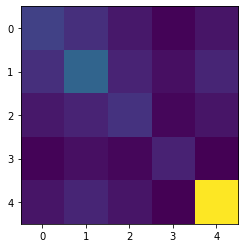

In [5]:
# plot sigma
print("print the covariance terms")
plt.imshow(sigma, interpolation='nearest')
plt.show()

In [6]:
q = 0.05                   # set risk factor
budget = num_assets // 2  # set budget - this is floor division
penalty = num_assets      # set parameter to scale the budget penalty term

qubitOp, offset = portfolio.get_operator(mu,sigma,q,budget,penalty)
#qubitOp is used to run the quantum algorithm and offset 

/usr/local/lib/python3.7/dist-packages/qiskit/finance/applications/ising/portfolio.py:84: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  return WeightedPauliOperator(paulis=pauli_list), offset


In [7]:
print("budget", budget, "penalty", penalty, "qubitOp", qubitOp, "offset", offset)

budget 2 penalty 5 qubitOp Representation: paulis, qubits: 5, size: 15 offset 7.498412964453026


In [8]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))

    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, q, budget, penalty)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))


In [9]:
# This uses eigenvalues using classical methods

exact_eigensolver = NumPyMinimumEigensolver(qubitOp)
result = exact_eigensolver.run()

print_result(result)
print("This result suggests stock number with ID")


Optimal: selection [0 1 0 0 1], value -0.0030

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 1]	-0.0030		1.0000
[1 1 1 1 1]	44.9969		0.0000
[0 1 1 1 0]	4.9990		0.0000
[1 0 0 0 0]	5.0002		0.0000
[0 1 0 0 0]	4.9994		0.0000
[1 1 0 0 0]	-0.0004		0.0000
[0 0 1 0 0]	4.9999		0.0000
[1 0 1 0 0]	0.0001		0.0000
[0 1 1 0 0]	-0.0007		0.0000
[1 1 1 0 0]	4.9996		0.0000
[0 0 0 1 0]	4.9996		0.0000
[1 0 0 1 0]	-0.0001		0.0000
[0 1 0 1 0]	-0.0010		0.0000
[1 1 0 1 0]	4.9993		0.0000
[0 0 1 1 0]	-0.0005		0.0000
[1 0 1 1 0]	4.9998		0.0000
[1 1 1 1 0]	19.9992		0.0000
[0 1 1 1 1]	19.9966		0.0000
[0 0 0 0 1]	4.9976		0.0000
[1 0 0 0 1]	-0.0021		0.0000
[1 1 0 0 1]	4.9973		0.0000
[0 0 1 0 1]	-0.0025		0.0000
[1 0 1 0 1]	4.9978		0.0000
[0 1 1 0 1]	4.9970		0.0000
[1 1 1 0 1]	19.9972		0.0000
[0 0 0 1 1]	-0.0027		0.0000
[1 0 0 1 1]	4.9975		0.0000
[0 1 0 1 1]	4.9967		0.0000
[1 1 0 1 1]	19.9969		0.0000
[0 0 1 1 1]	4.9972		0.0

/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:38: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  'qiskit-terra')
/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:38: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  'qiskit-terra')
/usr/local/lib/python3.7/dist-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:215: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to q

In [11]:
# Running QAOA 
backend = Aer.get_backend('statevector_simulator')
seed = 100

cobyla = COBYLA()
cobyla.set_options(maxiter=1000)
qaoa = QAOA(operator=qubitOp,optimizer=cobyla, p=3)

qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = qaoa.run(quantum_instance)

print_result(result)


print("This method finds two answer to be equally best")
print("Setting penalty = 1.0 gave us the best portfolio, still 1/6")
print("This has no variation - same answer every time - not probabilistic")
print("QAOA risk = 0.05, gave the best answer with a low probability")
print("QAOA works with 5 assets - probability same but it found the best answer on top")

Optimal: selection [1. 0. 1. 0. 0.], value 0.0001

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 1 0 0]	0.0001		0.0741
[1 0 0 1 0]	-0.0001		0.0739
[1 1 0 0 0]	-0.0004		0.0739
[0 0 1 1 0]	-0.0005		0.0738
[0 1 1 0 0]	-0.0007		0.0737
[0 1 0 1 0]	-0.0010		0.0736
[1 0 0 0 1]	-0.0021		0.0732
[0 0 1 0 1]	-0.0025		0.0731
[0 0 0 1 1]	-0.0027		0.0730
[0 1 0 0 1]	-0.0030		0.0729
[1 0 1 1 0]	4.9998		0.0205
[1 1 1 0 0]	4.9996		0.0205
[1 1 0 1 0]	4.9993		0.0205
[0 1 1 1 0]	4.9990		0.0204
[1 0 1 0 1]	4.9978		0.0202
[1 0 0 1 1]	4.9975		0.0202
[1 1 0 0 1]	4.9973		0.0201
[0 0 1 1 1]	4.9972		0.0201
[0 1 1 0 1]	4.9970		0.0201
[0 1 0 1 1]	4.9967		0.0200
[1 0 0 0 0]	5.0002		0.0107
[0 0 1 0 0]	4.9999		0.0106
[0 0 0 1 0]	4.9996		0.0106
[0 1 0 0 0]	4.9994		0.0106
[0 0 0 0 1]	4.9976		0.0104
[0 0 0 0 0]	20.0000		0.0045
[1 1 1 1 1]	44.9969		0.0033
[0 1 1 1 1]	19.9966		0.0003
[1 1 0 1 1]	19.9969		0.0003
[1 1 1 0 1]	19.9972	

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright